In [283]:
from lstm_model import build_open_loop_lstm, load_open_loop_lstm
from data_processing import create_training_split, df_training_split, create_df_3d, create_window_closed_loop, add_new_pred, compute_lyapunov_time_arr, train_valid_test_split, df_train_valid_test_split
import warnings
import seaborn as sns
import datetime
import random
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import tensorflow_datasets as tfds
plt.rcParams['figure.facecolor'] = 'w'
warnings.simplefilter(action='ignore', category=FutureWarning)

np.random.seed(1234)
tf.random.set_seed(1234)

In [174]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [175]:
%rm -rf ./logs/LSTM250_washout0

In [322]:
mydf = np.genfromtxt('CSV/lorenz_stand.csv', delimiter=',')
time = mydf[0, :]
mydf = mydf[1:, :]
df_train, df_valid, df_test = df_train_valid_test_split(mydf)
time_train, time_valid, time_test = train_valid_test_split(time)
x_train, x_valid, x_test = train_valid_test_split(mydf[0, :])
y_train, y_valid, y_test = train_valid_test_split(mydf[1, :])
z_train, z_valid, z_test = train_valid_test_split(mydf[2, :])

In [318]:
window_size = 50
batch_size = 32
shuffle_buffer_size = df_train.shape[0]
train_dataset = create_df_3d(df_train.transpose(
), window_size, batch_size, shuffle_buffer_size)
valid_dataset = create_df_3d(df_valid.transpose(), window_size, batch_size, 1)
test_dataset = create_df_3d(df_test.transpose(), window_size, batch_size, 1)

In [319]:
def custom_loss(y_true, y_pred, washout=10):
    mse = tf.keras.losses.MeanSquaredError()
    # (batchsize, dimensions)
    loss = mse(y_true[washout:, :], y_pred[washout:, :])
    return loss

In [321]:
def build_open_loop_lstm():
    lstm_init = tf.keras.initializers.GlorotUniform(seed=0)
    dense_init = tf.keras.initializers.GlorotUniform(seed=1)
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(50, activation='tanh',
                             name='LSTM_1', kernel_initializer=lstm_init),
        tf.keras.layers.Dense(3, name='Dense_1', kernel_initializer=dense_init)
    ])
    optimizer = tf.keras.optimizers.Adam()
    mse_loss = tf.keras.losses.MeanSquaredError()
    model.compile(loss=custom_loss, optimizer=optimizer, metrics=['mse'])
    return model

Epoch 1/100
186/186 [==============================] - 5s 15ms/step - loss: 0.0188 - mse: 0.0188 - val_loss: 0.0038 - val_mse: 0.0039
Epoch 2/100
186/186 [==============================] - 3s 14ms/step - loss: 0.0015 - mse: 0.0014 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 3/100
186/186 [==============================] - 2s 13ms/step - loss: 4.3485e-04 - mse: 4.2630e-04 - val_loss: 7.9954e-04 - val_mse: 7.9162e-04
Epoch 4/100
186/186 [==============================] - 2s 13ms/step - loss: 2.8096e-04 - mse: 2.7726e-04 - val_loss: 4.2013e-04 - val_mse: 4.1240e-04
Epoch 5/100
186/186 [==============================] - 2s 13ms/step - loss: 1.7005e-04 - mse: 1.6657e-04 - val_loss: 3.3796e-04 - val_mse: 3.3044e-04
Epoch 6/100
186/186 [==============================] - 2s 13ms/step - loss: 1.4201e-04 - mse: 1.3716e-04 - val_loss: 2.9222e-04 - val_mse: 2.8612e-04
Epoch 7/100
186/186 [==============================] - 2s 13ms/step - loss: 1.1684e-04 - mse: 1.1170e-04 - val_loss: 2.5960e-04 - va

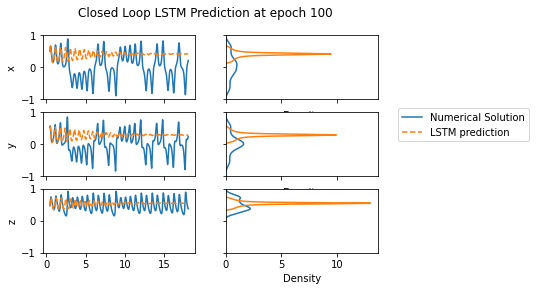

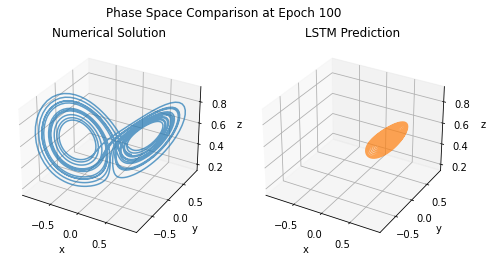

In [316]:
np.random.seed(1234)
tf.random.set_seed(1234)
model_oloop = build_open_loop_lstm()
log_dir = "50_window/logs/fit/LSTM250_washout10/" + \
    datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='loss', patience=10, restore_best_weights=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)

history = model_oloop.fit(train_dataset, epochs=100, batch_size=batch_size,
                          validation_data=valid_dataset, verbose=1, callbacks=[tensorboard_callback, early_stop_callback])

img_filepath = '50_window/Images/LSTM_10_washout/run_0902/'
lya_filepath = img_filepath + 'cloop_' + str(history.params['epochs'])+'.png'
predictions = plot_file.plot_closed_loop_lya(
    model_oloop, history.params['epochs'], time_test, df_test, lya_filepath, n_length=1950)
phase_filepath = img_filepath + 'phase_cloop_' + \
    str(history.params['epochs'])+'.png'
plot_file.plot_phase_space(
    predictions, history.params['epochs'], df_test, phase_filepath)

In [300]:
model = model_oloop

(320, 3)
(320, 50, 3) (320, 3)
Epoch 1/100
10/10 - 1s - loss: 7.3834e-06 - mse: 6.9193e-06 - val_loss: 3.6076e-04 - val_mse: 3.5897e-04 - 641ms/epoch - 64ms/step
Epoch 2/100
10/10 - 0s - loss: 3.6838e-06 - mse: 3.8691e-06 - val_loss: 3.4039e-04 - val_mse: 3.3926e-04 - 340ms/epoch - 34ms/step
Epoch 3/100
10/10 - 0s - loss: 3.4488e-06 - mse: 2.9638e-06 - val_loss: 3.3570e-04 - val_mse: 3.3412e-04 - 338ms/epoch - 34ms/step
Epoch 4/100
10/10 - 0s - loss: 2.4269e-06 - mse: 2.6138e-06 - val_loss: 3.4385e-04 - val_mse: 3.4258e-04 - 342ms/epoch - 34ms/step
Epoch 5/100
10/10 - 0s - loss: 2.6269e-06 - mse: 2.8324e-06 - val_loss: 3.3742e-04 - val_mse: 3.3603e-04 - 340ms/epoch - 34ms/step
Epoch 6/100
10/10 - 0s - loss: 3.2472e-06 - mse: 2.9760e-06 - val_loss: 3.3895e-04 - val_mse: 3.3739e-04 - 339ms/epoch - 34ms/step
Epoch 7/100
10/10 - 0s - loss: 3.0618e-06 - mse: 2.9790e-06 - val_loss: 3.3928e-04 - val_mse: 3.3802e-04 - 344ms/epoch - 34ms/step
Epoch 8/100
10/10 - 0s - loss: 2.7723e-06 - mse: 2.9

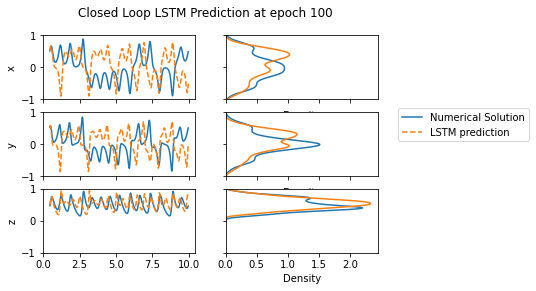

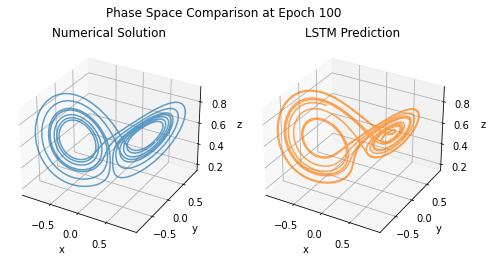

In [317]:
cloop_size = 32*10
test_window, labels, idx = select_random_window_with_label(
    df_train.transpose(), cloop_size)  # np.append(df_train[:, -50:], df_test, axis=1)
predictions = model.predict(np.array(test_window).reshape(cloop_size, 50, 3))

print(predictions.shape)
cloop_windows, cloop_label = add_cloop_prediction(
    df_train.transpose(), idx, predictions)
print(np.array(cloop_windows).shape, cloop_label.shape)

history = model.fit(cloop_windows, cloop_label, epochs=100, batch_size=32,
                    validation_data=valid_dataset, callbacks=[tensorboard_callback, early_stop_callback], verbose=2)

img_filepath = '50_window/Images/LSTM_10_washout/run_0902/'
lya_filepath = img_filepath + 'cloop_' + str(history.params['epochs'])+'.png'
predictions = plot_file.plot_closed_loop_lya(
    model, history.params['epochs'], time_test, df_test, lya_filepath, n_length=1050)
phase_filepath = img_filepath + 'phase_cloop_' + \
    str(history.params['epochs'])+'.png'
plot_file.plot_phase_space(
    predictions, history.params['epochs'], df_test, phase_filepath)

In [290]:
if not os.path.exists(img_filepath):
    os.makedirs(img_filepath)

In [289]:
np.random.seed(1234)
tf.random.set_seed(1234)
model_oloop = build_open_loop_lstm()
img_filepath = '50_window/Images/LSTM_10_washout/run_0902/'

n_epochs_old = 0
# Save the weights
for i in range(0, 5):
    n_epochs = n_epochs_old + 50
    history = model_oloop.fit(train_dataset, epochs=n_epochs, initial_epoch=n_epochs_old, batch_size=batch_size,
                              validation_data=valid_dataset, verbose=2)  # , callbacks=[tensorboard_callback]) #, early_stop_callback])
    n_epochs_old = n_epochs
    lya_filepath = img_filepath + 'cloop_' + str(n_epochs)+'.png'
    predictions = plot_file.plot_closed_loop_lya(
        model_oloop, n_epochs, time_test, df_test, lya_filepath, n_length=1950)
    phase_filepath = img_filepath + 'phase_cloop_' + str(n_epochs)+'.png'
    plot_file.plot_phase_space(predictions, n_epochs, df_test, phase_filepath)

Epoch 1/50


KeyboardInterrupt: 

In [ ]:
%tensorboard - -logdir logs/fit/LSTM250_washout0

In [172]:
model = model_oloop
forecast = model.predict(test_dataset)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


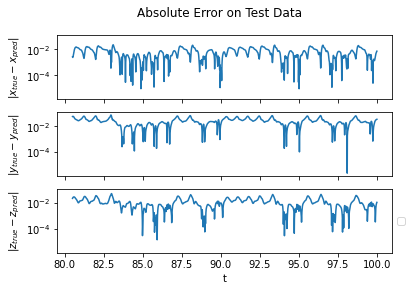

In [173]:
err = df_test.transpose()[50:, :] - forecast
abs_error = np.abs(df_test.transpose()[50:, :] - forecast)

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True,
                                    sharey=True, facecolor='w')  # , figsize=(15, 15))
fig.suptitle('Absolute Error on Test Data')
ax1.plot(time_test[50:], abs_error[:, 0])
ax1.set_ylabel(r'$|x_{true}-x_{pred}|$')
ax1.set_yscale('log')
ax2.plot(time_test[50:], abs_error[:, 1])
ax2.set_ylabel(r'$|y_{true}-y_{pred}|$')
ax2.set_yscale('log')
ax3.plot(time_test[50:], abs_error[:, 2])
ax3.set_ylabel(r'$|z_{true}-z_{pred}|$')
ax3.set_xlabel('t')
ax3.set_yscale('log')
ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#fig.savefig(error_filepath, dpi=1000, facecolor="w")

In [183]:
model_checkpoint = 'oloop_lstm_Washout_0/250_epoch_cp'
# Save the weights
model_oloop.save_weights(model_checkpoint)

In [18]:
def select_random_window_with_label(df_transposed, n_windows, window_size=50, n_dim=3):
    idx = random.sample(range(len(df_transposed)-window_size-1), n_windows)
    window_list = np.array([df_transposed[i:i+window_size, :].reshape(window_size, 3)
                           for i in idx])  # .reshape((n_windows,window_size,n_dim))
    label_list = np.array([df_transposed[i+window_size+1, :].reshape(n_dim)
                          for i in idx])  # .reshape(n_windows, n_dim)
    return window_list, label_list, idx


def add_cloop_prediction(df_transposed, idx, predictions):
    window_list = np.array([np.append(df_train.transpose()[idx[i]+1:idx[i]+50, :],
                           predictions[i, :].reshape(1, 3), axis=0).reshape(50, 3) for i in range(0, len(idx))])
    label_list = np.array([df_transposed[i+52, :] for i in idx])
    return window_list, label_list

In [20]:
model = model_oloop

2022-02-04 13:53:51.822009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-04 13:53:51.870392: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


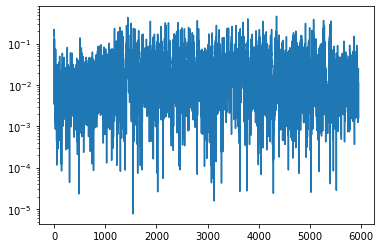

In [26]:
forecast = model.predict(train_dataset)
forecast_err = np.abs(df_train.transpose()[50:, :] - forecast)
plt.plot(forecast_err[:, 0])
plt.yscale('log')

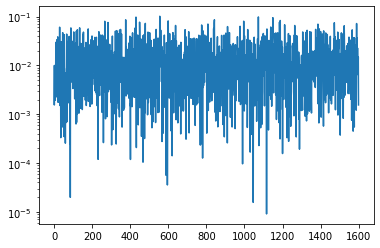

In [27]:
error = np.abs(labels - predictions)
plt.plot(error[:, 1])
plt.yscale('log')